# 📊 Proyecto Final de Estadística (MATCOM, UH) — Curso 2025–2026  
## Análisis Cuantitativo de Mercados Financieros (Acciones tecnológicas vs ETF de Oro)

**Equipo:** Juan Carlos Carmenate Díaz y Sebastian González Alfonso  
> **Fecha:** 12 de enero de 2026

Este notebook implementa las fases exigidas en la guía del proyecto:  
- **1** Definición del problema y recopilación de datos
- **2** Análisis Exploratorio de Datos (EDA)
- **3** Preparación de datos
- **4** Aplicación de Técnicas estadísticas
- **5** Resultados y Conclusiones.

> Guía del proyecto: *Orden.pdf*.

## 0. Preparación del entorno

En este trabajo se emplean bibliotecas estándar de análisis de datos en Python: `numpy`, `pandas`, `matplotlib`, `seaborn`, `scipy` y `scikit-learn`.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, confusion_matrix, classification_report
)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

---

## 1. Definición del Problema y Recopilación de Datos

### 📌 Problema
Los mercados financieros presentan **volatilidad**, **correlaciones** entre activos y **patrones temporales**. A partir de series históricas diarias, podemos aplicar técnicas estadísticas para comparar comportamiento, riesgo y relaciones entre activos.

### ❓ Preguntas de investigación
1. ¿Qué activo presenta mayor volatilidad en el período analizado?  
2. ¿Existen correlaciones significativas entre los rendimientos de los activos?  
3. ¿Se pueden identificar grupos (clusters) de activos según su comportamiento estadístico?  
4. ¿Se puede predecir la dirección diaria (sube/baja) de un activo usando variables simples?

### 📂 Datos
Se utilizan archivos CSV descargados y adjuntos al proyecto:

- **AAPL** (acción) — Apple Inc.  
- **MSFT** (acción) — Microsoft Corporation  
- **NVDA** (acción) — NVIDIA Corporation  
- **AAAU** (ETF) — Gold exchange-traded fund (fondo de inversión cotizado), respaldado por oro  

**Variables típicas en los CSV:** 
- `Date`: Fecha del evento, 
- `Open`: Precio de apertura de la acción, 
- `High`: Mayor valor alcanzado por la acción en el día,
- `Low`: Menor valor alcanzado por la acción en el día,
- `Close`: Precio de cierre de la acción,
- `Adj Close`: Precio de cierre de la acción ajustado para reflejar eventos corporativos y ser comparable en el tiempo, 
- `Volume`: Número de unidades (acciones o ETF) intercambidas en el día que refleja la actividad del mercado.

### 1.1. Recopilación de datos

> Si los CSV están dentro de una carpeta `data/`, cambia `DATA_DIR` a `"data"`.

In [ ]:
from pathlib import Path

DATA_DIR = Path("data")

files = {
    "AAPL": DATA_DIR / "AAPL.csv",
    "MSFT": DATA_DIR / "MSFT.csv",
    "NVDA": DATA_DIR / "NVDA.csv",
    "AAAU": DATA_DIR / "AAAU.csv",
}

for k, p in files.items():
    if not p.exists():
        raise FileNotFoundError(f"No se encuentra {p}. Ajusta DATA_DIR o el nombre del archivo.")

def load_asset(symbol: str, path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Normalizar nombres comunes
    if "Date" not in df.columns:
        raise ValueError(f"{symbol}: no existe columna 'Date'. Columnas: {list(df.columns)}")
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").drop_duplicates(subset=["Date"])

    # Algunas fuentes usan 'Adj Close' y otras 'Adj_Close'
    if "Adj Close" not in df.columns and "Adj_Close" in df.columns:
        df = df.rename(columns={"Adj_Close":"Adj Close"})

    # Asegurar que precios/volumen sean numéricos
    for col in ["Open","High","Low","Close","Adj Close","Volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df.reset_index(drop=True)

assets = {sym: load_asset(sym, path) for sym, path in files.items()}
{k: v.head(3) for k, v in assets.items()}

{'AAPL':         Date      Open      High       Low     Close  Adj Close     Volume
 0 1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400
 1 1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200
 2 1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000,
 'MSFT':         Date      Open      High       Low     Close  Adj Close      Volume
 0 1986-03-13  0.088542  0.101562  0.088542  0.097222   0.062378  1031788800
 1 1986-03-14  0.097222  0.102431  0.097222  0.100694   0.064606   308160000
 2 1986-03-17  0.100694  0.103299  0.100694  0.102431   0.065720   133171200,
 'NVDA':         Date      Open      High       Low     Close  Adj Close      Volume
 0 1999-01-22  1.750000  1.953125  1.552083  1.640625   1.509998  67867200.0
 1 1999-01-25  1.770833  1.833333  1.640625  1.812500   1.668188  12762000.0
 2 1999-01-26  1.833333  1.869792  1.645833  1.671875   1.538759   8580000.0,
 'AAAU':         Date   Open   High    Low  Close  Ad

### 1.2. Revisión rápida (calidad y rango temporal)

In [ ]:
summary = []
for sym, df in assets.items():
    summary.append({
        "Asset": sym,
        "Rows": len(df),
        "Start": df["Date"].min().date(),
        "End": df["Date"].max().date(),
        "Missing_Close": int(df["Close"].isna().sum()) if "Close" in df.columns else None,
        "Missing_AdjClose": int(df["Adj Close"].isna().sum()) if "Adj Close" in df.columns else None,
        "Missing_Volume": int(df["Volume"].isna().sum()) if "Volume" in df.columns else None,
    })
pd.DataFrame(summary)

,Asset,Rows,Start,End,Missing_Close,Missing_AdjClose,Missing_Volume
0,AAPL,9909,1980-12-12,2020-04-01,0,0,0
1,MSFT,8584,1986-03-13,2020-04-01,0,0,0
2,NVDA,5334,1999-01-22,2020-04-01,1,1,1
3,AAAU,410,2018-08-15,2020-04-01,0,0,0


### 1.2.1 Consideraciones sobre Cobertura Temporal

Como se observa en la tabla anterior, **AAAU** posee el historial más corto (410 filas, 2018-08-15 a 2020-04-01), 
mientras que **AAPL**, **MSFT** y **NVDA** tienen datos históricos que se remontan a décadas. Para garantizar comparabilidad 
y simultaneidad en análisis multivariados (correlaciones, PCA, clustering, clasificación), todas las técnicas 
se aplicarán sobre la intersección temporal, es decir, fechas donde existen observaciones válidas para 
los cuatro activos simultáneamente.

Esto resulta en un período de análisis efectivo de **409 observaciones diarias** (2018-08-15 a 2020-04-01), 
que coincide con un sub-período de volatilidad moderada a alta (incluye la caída de marzo de 2020 por COVID-19). 
Por tanto, las conclusiones obtenidas deben interpretarse en el contexto de este sub-período específico y pueden no 
generalizarse a períodos más largos o diferentes ciclos económicos.

---

## 2. Análisis Exploratorio de Datos (EDA)

En finanzas, el análisis se hace típicamente sobre **rendimientos** en lugar de precios. Aquí usaremos:

- Rendimiento simple: $ r_t = \frac{P_t - P_{t-1}}{P_{t-1}} $

- Rendimiento logarítmico: $ \ell_t = \ln(P_t) - \ln(P_{t-1}) $

Trabajaremos con `Adj Close` si está disponible; en caso contrario, `Close`.

In [ ]:
def pick_price_col(df: pd.DataFrame) -> str:
    return "Adj Close" if "Adj Close" in df.columns and df["Adj Close"].notna().any() else "Close"

price_cols = {sym: pick_price_col(df) for sym, df in assets.items()}
price_cols

{'AAPL': 'Adj Close',
 'MSFT': 'Adj Close',
 'NVDA': 'Adj Close',
 'AAAU': 'Adj Close'}

In [ ]:
def add_returns(df: pd.DataFrame, price_col: str) -> pd.DataFrame:
    out = df.copy()
    out["price"] = out[price_col]
    out["ret"] = out["price"].pct_change()
    out["logret"] = out["price"].apply(np.log).diff()
    return out

assets_ret = {sym: add_returns(df, price_cols[sym]) for sym, df in assets.items()}

# Dataset combinado por fecha (rendimientos)
rets = (
    pd.concat(
        [df[["Date","ret","logret"]].assign(Asset=sym) for sym, df in assets_ret.items()],
        ignore_index=True
    )
    .dropna(subset=["ret","logret"])
)

wide = rets.pivot_table(index="Date", columns="Asset", values="ret").dropna()

rets.head()

,Date,ret,logret,Asset
1,1980-12-15,-0.052174,-0.053584,AAPL
2,1980-12-16,-0.073395,-0.076227,AAPL
3,1980-12-17,0.024752,0.024451,AAPL
4,1980-12-18,0.028986,0.028574,AAPL
5,1980-12-19,0.061033,0.059243,AAPL


### 2.1. Estadísticos descriptivos (rendimientos)

Incluye medidas de tendencia central y dispersión; además curtosis y asimetría para describir colas y sesgo.

In [ ]:
desc = (
    rets.groupby("Asset")[["ret","logret"]]
    .agg(["count","mean","std","min","max", stats.skew, stats.kurtosis])
)
desc

ret                                                              logret                                                    \
      count      mean       std       min       max      skew   kurtosis  count      mean       std       min       max      skew   
Asset                                                                                                                               
AAAU    409  0.000778  0.009008 -0.040416  0.056165  0.321660   6.406208    409  0.000737  0.008991 -0.041256  0.054645  0.211186   
AAPL   9908  0.001065  0.028735 -0.518692  0.332278 -0.384935  18.009918   9908  0.000644  0.029188 -0.731247  0.286891 -1.766512   
MSFT   8583  0.001142  0.021532 -0.301159  0.195652 -0.112242  11.037789   8583  0.000909  0.021603 -0.358332  0.178691 -0.598766   
NVDA   5331  0.001723  0.038833 -0.352335  0.424146  0.622322  12.050838   5331  0.000973  0.038688 -0.434382  0.353572 -0.194690   

                  
        kurtosis  
Asset             
AAAU    6.178703  
AAPL   46.692964  
MSFT   15.299536  
NVDA   12.992073

### 2.1.1: Prueba de Normalidad de Rendimientos

La normalidad es un supuesto común en muchos modelos financieros. Sin embargo, los datos financieros empíricos frecuentemente exhiben colas pesadas (curtosis > 3) y asimetría, lo que viola dicha suposición. Para evaluar si nuestros rendimientos se distribuyen normalmente, empleamos la Prueba de Kolmogorov-Smirnov (KS).

La prueba KS es particularmente adecuada para nuestro análisis. Con $n = 409$ observaciones diarias, es asintóticamente válida y mantiene potencia estadística superior a otras alternativas (como Shapiro-Wilk, diseñada para $n < 50$). No requiere estimación de parámetros adicionales más allá de media y desviación estándar, lo que la hace menos sensible a outliers extremos que tests basados en momentos (como Jarque-Bera).

Es un test no-paramétrico que contrasta:

$$H_0: F(r_t) = \Phi\left(\frac{r_t - \bar{r}}{\sigma_r}\right) \quad \text{(los rendimientos son normales)}$$

$$H_1: F(r_t) \neq \Phi\left(\frac{r_t - \bar{r}}{\sigma_r}\right) \quad \text{(los rendimientos no son normales)}$$

donde $F(r_t)$ es la distribución empírica acumulada (CDF) y $\Phi(\cdot)$ es la CDF de la normal estándar.

El estadístico de pruebase  define como:

$$D = \sup_{r} \left| F_n(r) - F(r) \right|$$

donde $F_n(r)$ es la CDF empírica (proporción de observaciones $\leq r$) y $F(r)$ es la CDF normal teórica. 
El estadístico $D$ mide la máxima distancia vertical entre ambas funciones acumuladas.

Bajo $H_0$ (normalidad), el estadístico $D$ sigue una distribución de Kolmogorov con distribución 
asintótica conocida. Se rechaza $H_0$ si $D$ es lo suficientemente grande, es decir, si las 
distribuciones empírica y teórica divergen significativamente.

Esta prueba detecta desviaciones de la normalidad en cualquier parte de la distribución (especialmente en colas), no asume homocedasticidad (importante con varianzas heterogéneas) y se basa en una interpretación geométrica clara: la máxima distancia vertical entre CDFs.

In [ ]:
#  Prueba de Kolmogorov-Smirnov para normalidad de rendimientos

from scipy.stats import kstest

print("=== Prueba de Kolmogorov-Smirnov para Normalidad de Rendimientos ===\n")

ks_results = []

for sym in wide.columns:
    ret_data = wide[sym].dropna().to_numpy()
    
    # Kolmogorov-Smirnov test
    # Compara contra distribución normal con parámetros estimados de la muestra
    ks_stat, ks_pval = kstest(ret_data, 'norm', args=(ret_data.mean(), ret_data.std()))
    
    ks_results.append({
        'Asset': sym,
        'KS_statistic': float(ks_stat),
        'KS_p_value': float(ks_pval),
        'Reject_H0_@_0.05': float(ks_pval) < 0.05,
        'n_observations': len(ret_data),
    })

ks_df = pd.DataFrame(ks_results)
print(ks_df.to_string(index=False))

=== Prueba de Kolmogorov-Smirnov para Normalidad de Rendimientos ===

Asset  KS_statistic  KS_p_value  Reject_H0_@_0.05  n_observations
 AAAU      0.103369    0.000294              True             409
 AAPL      0.108403    0.000122              True             409
 MSFT      0.120888    0.000011              True             409
 NVDA      0.092104    0.001805              True             409


#### Conclusión

La prueba de Kolmogorov-Smirnov rechaza decisivamente la hipótesis nula de normalidad para los cuatro activos analizados. El estadístico KS más alto se observa en **MSFT** con $D = 0.120888$ ($p$-valor $= 0.000011$), mientras que el más bajo es **NVDA** con $D = 0.092104$ ($p$-valor $= 0.001805$). Todos los p-valores están muy por debajo del nivel de significancia $\alpha = 0.05$, confirmando que **los rendimientos no siguen una distribución normal** en ningún caso.

Devido a este resultado, los modelos que asumen normalidad, como la regresión lineal, pueden ser inapropiados o subestimar riesgos. Además, se hace necesario utilizar técnicas estadísticas que no dependan de normalidad y consideren distribuciones con colas pesadas en lugar de asumir campana de Gauss.

### 2.2. Series temporales de precios

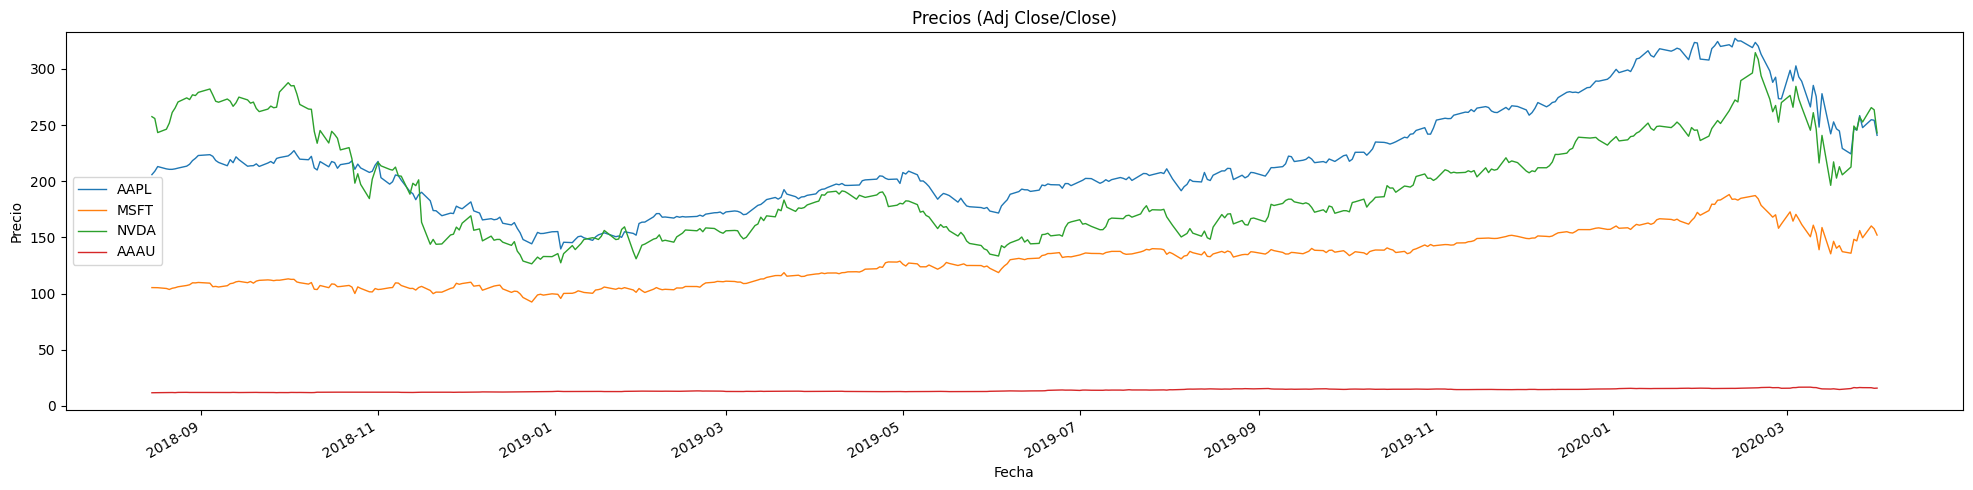

In [ ]:
# Series temporales de precios (ajustando escala y tamaño según duración)
import matplotlib.dates as mdates

start = pd.Timestamp('2018-08-15')  # Fecha de inicio (ej: pd.Timestamp('2019-01-01')) o None para primer dato
end = None   # Fecha de fin (ej: pd.Timestamp('2020-01-01')) o None para último dato

# Aplicar filtro temporal si se definen start/end
all_dates = pd.concat([df['Date'] for df in assets_ret.values() if 'Date' in df.columns and not df['Date'].dropna().empty])
date_filter_start = start if start is not None else all_dates.min()
date_filter_end = end if end is not None else all_dates.max()

# Calcular duración del rango a mostrar para ajustar el ancho de la figura
n_days = (date_filter_end - date_filter_start).days if len(all_dates) > 0 else 1
fig_w = max(10, min(20, n_days / 30))  # ancho dinámico entre 10 y 20 según rango a mostrar

fig, ax = plt.subplots(figsize=(fig_w, 5))

# Construir lista de precios sobre el rango de fechas a mostrar
prices_list_filtered = []
for sym, df in assets_ret.items():
    if 'Date' in df.columns and 'price' in df.columns:
        filtered_df = df[(df['Date'] >= date_filter_start) & (df['Date'] <= date_filter_end)]
        if filtered_df['price'].dropna().size > 0:
            prices_list_filtered.append(filtered_df['price'].dropna().to_numpy())

if prices_list_filtered:
    all_prices_filtered = np.concatenate(prices_list_filtered)
else:
    all_prices_filtered = np.array([])

# Usar percentiles 1%-99% sobre datos filtrados para fijar límites dinámicos
if all_prices_filtered.size > 0:
    ylow, yhigh = np.nanpercentile(all_prices_filtered, [1, 99])
    ypad = 0.05 * (yhigh - ylow) if (yhigh - ylow) > 0 else (abs(yhigh) * 0.05 if yhigh != 0 else 0.05)
    ax.set_ylim(ylow - ypad, yhigh + ypad)

# Graficar los datos del rango seleccionado
for sym, df in assets_ret.items():
    if 'Date' in df.columns and 'price' in df.columns:
        filtered_df = df[(df['Date'] >= date_filter_start) & (df['Date'] <= date_filter_end)]
        ax.plot(filtered_df["Date"], filtered_df["price"], label=sym, lw=1)

ax.set_title("Precios (Adj Close/Close)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio")
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()
plt.show()

### 2.3. Distribuciones: histogramas y boxplots de rendimientos

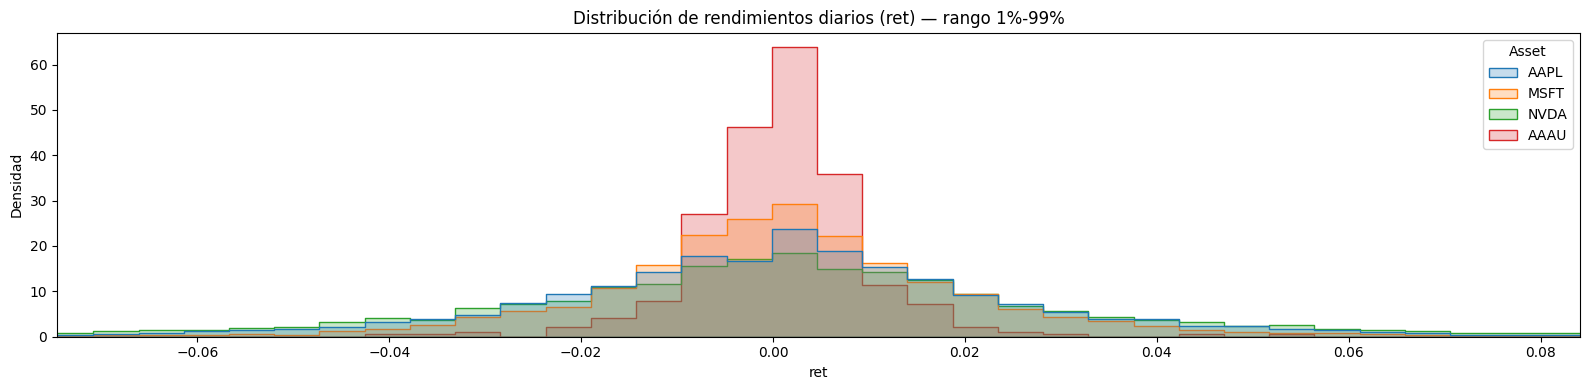

In [ ]:
# Histogramas ajustando bins y límites por percentiles
n = len(rets)
fig_w = max(8, min(16, n / 300))
plt.figure(figsize=(fig_w, 4))
# limitar por percentiles para que los outliers no deformen la vista
low, high = rets['ret'].quantile([0.01, 0.99])
# bins dependientes del tamaño de la muestra
bins = int(np.clip(n / 10, 30, 200))

sns.histplot(data=rets, x="ret", hue="Asset", element="step", stat="density", common_norm=False, bins=bins)
plt.xlim(low, high)
plt.title("Distribución de rendimientos diarios (ret) — rango 1%-99%")
plt.xlabel("ret")
plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

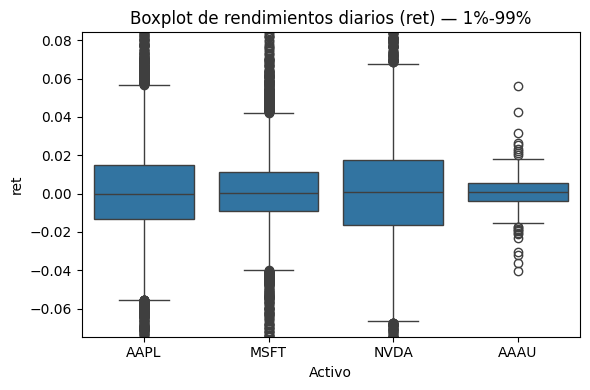

In [ ]:
# Boxplot con límites por percentiles y tamaño según número de activos
n_assets = rets['Asset'].nunique()
fig_w = max(6, n_assets * 1.2)
plt.figure(figsize=(fig_w, 4))
low, high = rets['ret'].quantile([0.01, 0.99])
sns.boxplot(data=rets, x="Asset", y="ret")
plt.ylim(low, high)
plt.title("Boxplot de rendimientos diarios (ret) — 1%-99%")
plt.xlabel("Activo")
plt.ylabel("ret")
plt.tight_layout()
plt.show()

### 2.4 Identificación y Análisis de Outliers

Los outliers en series financieras suelen corresponder a eventos de importancia económica o de mercado (shocks) que permiten entender episodios de estrés sistémico y preparar modelos que manejen colas pesadas. Constituyen rendimientos que se desvían significativamente del comportamiento típico de cada activo, identificados mediante el criterio **z-score > 3** (desviaciones superiores a 3 veces la desviación estándar) o el método **IQR** (rango intercuartílico).

In [ ]:
# Identificación de outliers mediante z-score e IQR

from scipy.stats import zscore

def identify_outliers(df: pd.DataFrame, column: str, method: str = 'zscore', threshold: float = 3) -> pd.DataFrame:
    if method == 'zscore':
        non_nan_df = df.dropna()
        non_nan_column = non_nan_df[column].dropna()
        z = np.abs(zscore(non_nan_column))
        outliers_mask = z > threshold
        outliers = non_nan_df[outliers_mask].copy()
    elif method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        outliers_mask = (df[column] < lower) | (df[column] > upper)
        outliers = df[outliers_mask].copy()
    else:
        raise ValueError("method debe ser 'zscore' o 'iqr'")
    
    return outliers.sort_values(column, key=abs, ascending=False)

# Aplicar a rendimientos diarios (usando z-score con threshold=3)
print("=== Outliers en Rendimientos Diarios (z-score > 3) ===\n")

outliers_collection = {}
for sym, df in assets_ret.items():
    outs = identify_outliers(df, 'ret', method='zscore', threshold=3)
    if len(outs) > 0:
        print(f"\n{sym}: {len(outs)} outliers")
        print(outs[['Date','ret','price']].head(10).to_string(index=False))
        outliers_collection[sym] = outs
    else:
        print(f"\n{sym}: sin outliers (z-score > 3)")

# Análisis de eventos extremos en la intersección temporal
try:
    wide = rets.pivot_table(index="Date", columns="Asset", values="ret").dropna()
except Exception as e:
    wide = None

if wide is not None and hasattr(wide, "shape"):
    print(f"\n\nRendimientos más extremos (top 10 por |ret|) en los {wide.shape[0]} días comunes:\n")

    extreme = wide.abs().stack().reset_index()
    extreme.columns = ["Date", "Asset", "abs_ret"]
    extreme = extreme.sort_values("abs_ret", ascending=False).head(10)
    print(extreme.to_string(index=False))

=== Outliers en Rendimientos Diarios (z-score > 3) ===


AAPL: 126 outliers
      Date       ret    price
2000-09-29 -0.518692 1.596575
1997-08-06  0.332278 0.815726
1983-09-23 -0.253846 0.343111
1987-10-19 -0.243523 1.035775
1998-01-02  0.238095 0.503774
1996-07-18  0.237037 0.647155
1993-07-16 -0.230769 0.824564
1987-10-26 -0.211268 0.794567
1998-01-06  0.192913 0.587090
1993-10-15  0.189474 0.850785

MSFT: 122 outliers
      Date       ret      price
1987-10-19 -0.301159   0.201615
2000-10-19  0.195652  19.849651
1987-10-26 -0.186528   0.174882
2008-10-13  0.186046  19.426094
1987-10-21  0.179687   0.252298
1987-10-29  0.157576   0.212754
2000-04-24 -0.155978  21.373466
2020-03-16 -0.147390 135.419998
2000-04-03 -0.144706  29.152929
2020-03-13  0.142169 158.830002

NVDA: 73 outliers
      Date       ret     price
2000-03-07  0.424146  6.389926
2004-08-06 -0.352335  2.893059
2003-05-09  0.330635  6.556170
2002-07-31 -0.317509  3.396200
2008-07-03 -0.307265 11.495540
2001-01-03  0.306

**Resultados por Activo:**

Como era esperado, los más extremos corresponden a fechas históricas de importancia y eventos de estrés sistémico.

- **AAPL:** 126 outliers. Ejemplos: 
    - 2000-09-29 con -51.9%: caída de septiembre 2000 durante el crash de las dot-com 
    - 1987-10-19: "Lunes Negro"

- **MSFT:** 122 outliers. Ejemplos:
    - 2000-09-29 con -51.9%: caída de septiembre 2000 durante el crash de las dot-com 
    - 1987-10-19: "Lunes Negro"
    - 2020-03 con con -14.7%: caída de marzo 2020 por COVID-19

- **NVDA:** 73 outliers. Ejemplos:
    - 2000-03-07 con +42.4%: mayor movimiento extremo positivo (burbuja tecnológica) 
    - 2000-2004: patrones de volatilidad pronunciada por crisis tecnológicas.

- **AAAU (Gold ETF):** Solo 7 outliers, todos concentrados en marzo 2020. El oro actúa como **activo refugio**, mostrando movimientos moderados incluso en periodos de estrés, reflejando su rol de cobertura contra la volatilidad de las acciones.

**Conclusiones:**

El período de análisis (2018-08-15 a 2020-04-01) captura la crisis de COVID-19 de marzo 2020. Los rendimientos más extremos en la intersección temporal son:

- **2018-11-16 (NVDA):** +18.76% — reacción a sorpresas positivas en noticias de tecnología.
- **2020-03-16 (NVDA, MSFT, AAPL):** Máximos globales de volatilidad durante el pánico de mercado por confinamiento global.

Esto confirma que en periodos de estrés sistémico, los outliers se concentran y reflejan cambios abruptos en la demanda de activos de riesgo (acciones) versus activos defensivos (oro). Su identificación permite detectar eventos de importancia económica y preparar modelos estadísticos que manejen adecuadamente colas pesadas en distribuciones financieras.

### 2.5. Correlaciones entre activos (sobre rendimientos)

Creamos una tabla por fecha con rendimientos de cada activo y calculamos la matriz de correlación.

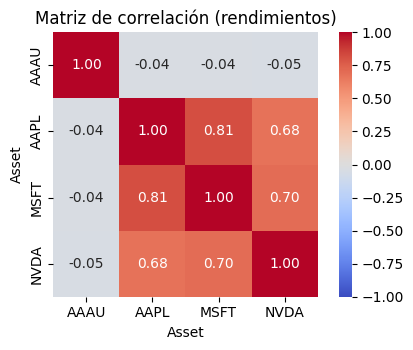

Asset,AAAU,AAPL,MSFT,NVDA
Asset,,,,
AAAU,1.000000,-0.038661,-0.035835,-0.045407
AAPL,-0.038661,1.000000,0.813582,0.676136
MSFT,-0.035835,0.813582,1.000000,0.700779
NVDA,-0.045407,0.676136,0.700779,1.000000


In [ ]:
corr = wide.corr()

# Tamaño relativo según número de activos
n_assets = corr.shape[0]
fig_w = max(4, n_assets * 1.2)
fig_h = max(3, n_assets * 0.9)
plt.figure(figsize=(fig_w, fig_h))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm", square=True)
plt.title("Matriz de correlación (rendimientos)")
plt.tight_layout()
plt.show()

corr

### 2.5.1 Scatter Plots: Visualización de Relaciones Pairwise

Para complementar el análisis de correlaciones, se visualizarán los scatter plots de todos los pares de activos. 
Esta representación permite identificar patrones no-lineales, outliers conjuntos, y la fuerza de la relación lineal 
entre cada pareja. Las correlaciones altas (ρ > 0.6) se manifiestan como nubes de puntos elongadas, mientras que 
correlaciones bajas se ven como nubes más redondeadas.

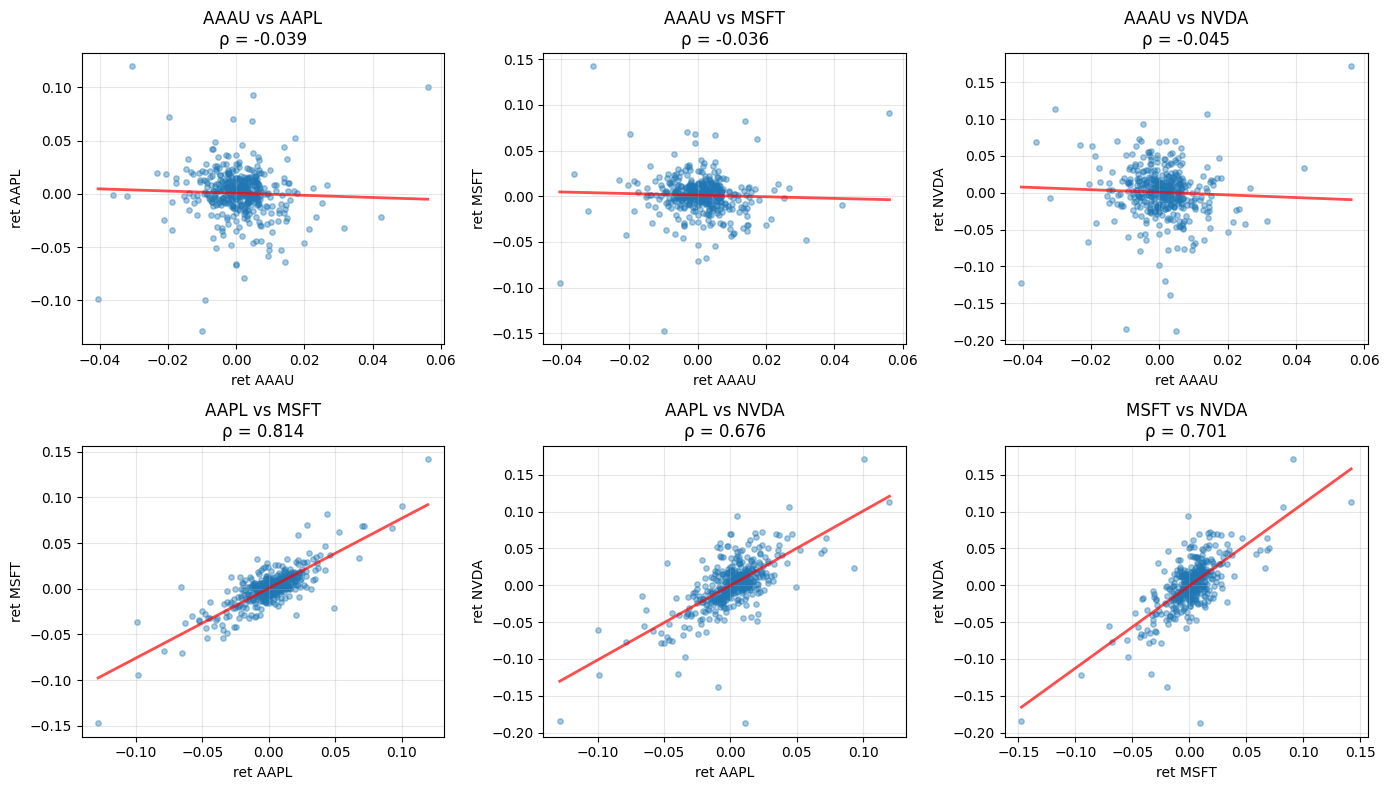

In [ ]:
# Scatter plots entre todos los pares de activos

from itertools import combinations

assets_list = list(wide.columns)
pairs = list(combinations(assets_list, 2))

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, (ax, (sym_a, sym_b)) in enumerate(zip(axes, pairs)):
    ax.scatter(wide[sym_a], wide[sym_b], alpha=0.4, s=15)
    
    # Línea de regresión
    z = np.polyfit(wide[sym_a], wide[sym_b], 1)
    p = np.poly1d(z)
    x_line = np.linspace(wide[sym_a].min(), wide[sym_a].max(), 100)
    ax.plot(x_line, p(x_line), 'r-', lw=2, alpha=0.7)
    
    rho = wide[[sym_a, sym_b]].corr().iloc[0, 1]
    ax.set_title(f'{sym_a} vs {sym_b}\nρ = {rho:.3f}')
    ax.set_xlabel(f'ret {sym_a}')
    ax.set_ylabel(f'ret {sym_b}')
    ax.grid(alpha=0.3)

# Esconder el último subplot si es necesario
if len(pairs) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()


---

## 3. Preparación de Datos

Acciones típicas:
- Manejo de valores faltantes (por ejemplo, eliminar fechas sin todos los activos).
- Estandarización (necesaria para PCA y K-Means).
- Construcción de variables para clasificación (sube/baja).

### 3.1. Dataset final para análisis multivariado

Se usarán fechas donde existan rendimientos para todos los activos (intersección).

In [ ]:
X = wide.copy()  # shape: (n_days, n_assets)
X.head()

Asset,AAAU,AAPL,MSFT,NVDA
Date,,,,
2018-08-16,0.000000,0.014650,-0.000186,-0.006330
2018-08-17,0.006814,0.019970,-0.000557,-0.049021
2018-08-20,0.006768,-0.009743,-0.006600,0.012336
2018-08-21,0.002521,-0.001949,-0.008328,0.022111
2018-08-22,0.002515,0.000047,0.010190,0.037502


### 3.2. Estandarización

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:3]

array([[-0.08643419,  0.59558663, -0.06027656, -0.19425497],
       [ 0.67097317,  0.82209064, -0.0771419 , -1.41063123],
       [ 0.6658469 , -0.44301483, -0.35146687,  0.33758328]])

### 3.3 Volatilidad Móvil

Además de la volatilidad general (std de toda la serie), se calculará la **volatilidad móvil** (rolling) usando una ventana de 20 días de trading. Esta medida captura cómo la variabilidad cambia en el tiempo, identificando períodos de estrés (alta volatilidad) y calma (baja volatilidad). Es útil para la detección de períodos homogéneos de similar riesgo, el modelado de riesgos y la ingeniería de vriables para mejorar predicciones, pues la volatilidad pasada es predictor del riesgo futuro.

In [ ]:
# Cálculo de volatilidad móvil (rolling)

window = 20  # ventana de 20 días de trading (approx 1 mes)

# Volatilidad móvil por activo
rolling_vol = wide.rolling(window=window, min_periods=1).std()

In [ ]:
# Estadísticas de volatilidad móvil
print(f"=== Estadísticas de Volatilidad Móvil ({window} días) ===\n")
vol_stats = rolling_vol.describe().T
print(vol_stats.round(5).to_string())

# Identificar períodos de máxima volatilidad
print(f"\n=== Top 5 fechas de mayor volatilidad móvil por activo ===\n")
for sym in wide.columns:
    top_vol_dates = rolling_vol[sym].nlargest(5)
    print(f"{sym}:")
    for date, vol in top_vol_dates.items():
        print(f"  {date.date()}: σ(20d) = {vol:.4f}")
    print()

=== Estadísticas de Volatilidad Móvil (20 días) ===

       count     mean      std      min      25%      50%      75%      max
Asset                                                                      
AAAU   408.0  0.00751  0.00350  0.00298  0.00553  0.00646  0.00828  0.02568
AAPL   408.0  0.01891  0.01111  0.00376  0.01151  0.01519  0.02179  0.06800
MSFT   408.0  0.01636  0.01184  0.00026  0.00980  0.01296  0.01856  0.07127
NVDA   408.0  0.02959  0.01550  0.01210  0.01961  0.02366  0.03536  0.08660

=== Top 5 fechas de mayor volatilidad móvil por activo ===

AAAU:
  2020-03-26: σ(20d) = 0.0257
  2020-03-25: σ(20d) = 0.0254
  2020-03-24: σ(20d) = 0.0252
  2020-04-01: σ(20d) = 0.0244
  2020-03-31: σ(20d) = 0.0243

AAPL:
  2020-03-27: σ(20d) = 0.0680
  2020-03-24: σ(20d) = 0.0678
  2020-03-25: σ(20d) = 0.0676
  2020-03-26: σ(20d) = 0.0674
  2020-03-30: σ(20d) = 0.0647

MSFT:
  2020-03-30: σ(20d) = 0.0713
  2020-03-27: σ(20d) = 0.0711
  2020-03-24: σ(20d) = 0.0710
  2020-03-25: σ(20d)

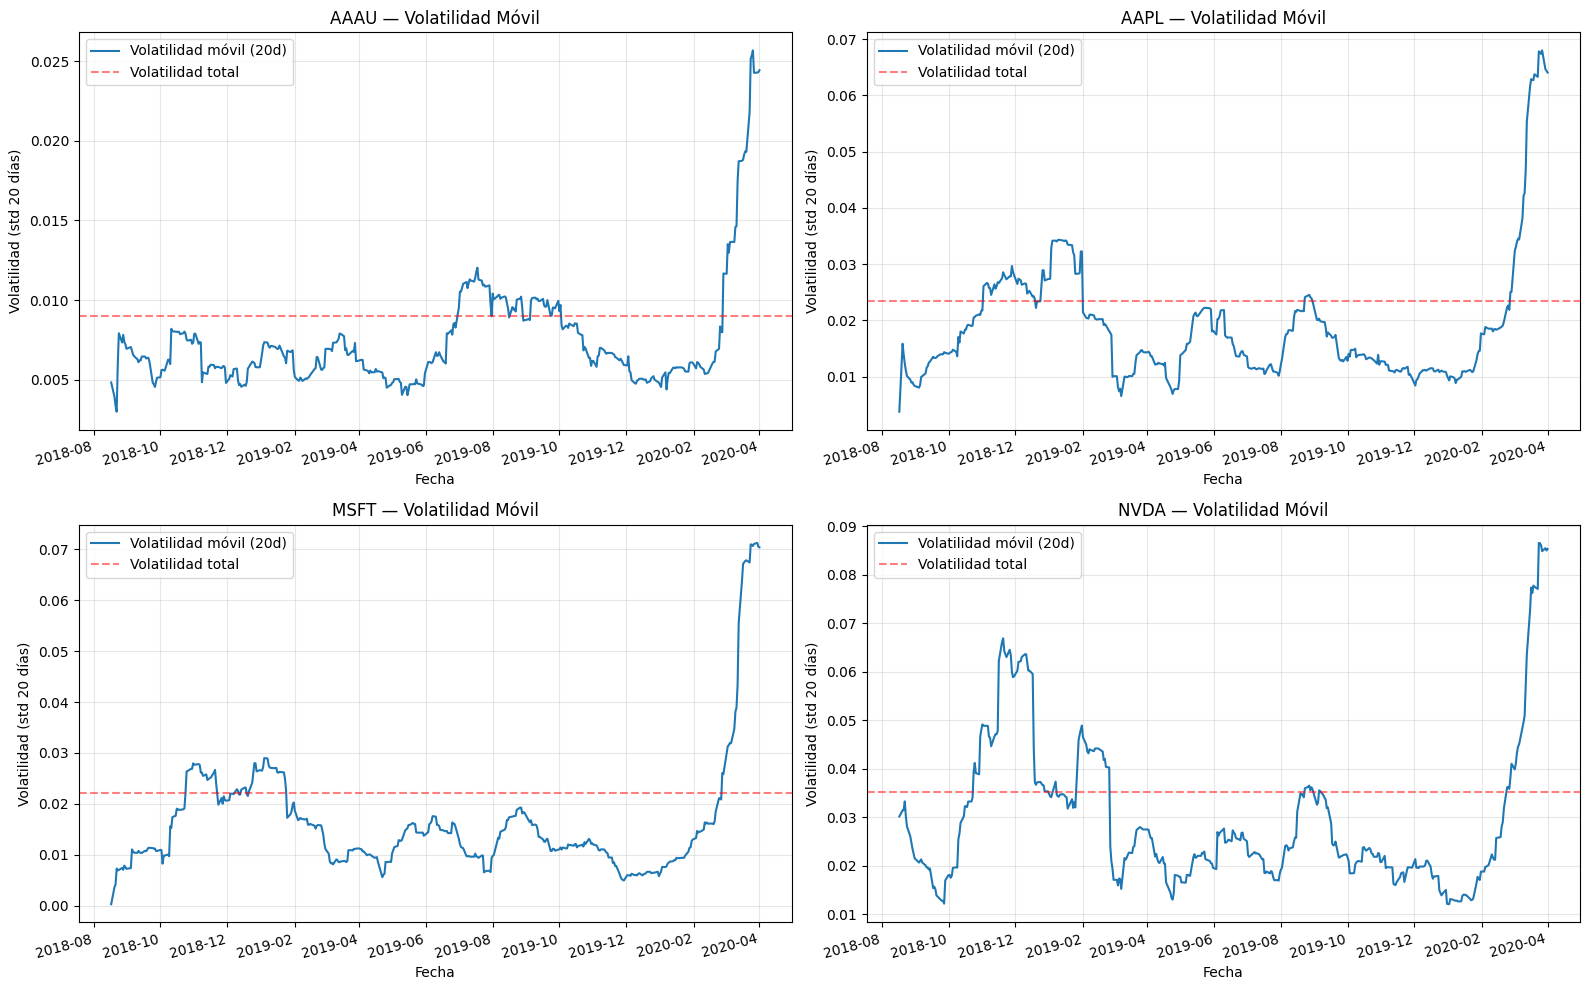

In [ ]:
# Visualizar volatilidad móvil para cada activo
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # Aumenta tamaño
axes = axes.flatten()

for idx, sym in enumerate(wide.columns):
    ax = axes[idx]
    ax.plot(rolling_vol.index, rolling_vol[sym], lw=1.5, label=f'Volatilidad móvil ({window}d)')
    ax.axhline(wide[sym].std(), color='red', linestyle='--', alpha=0.5, label='Volatilidad total')
    ax.set_title(f'{sym} — Volatilidad Móvil')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Volatilidad (std 20 días)')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Formatear eje x: reduce ticks y rota etiquetas
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Cada 2 meses
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=15, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
# Crear dataset enriquecido con volatilidad móvil
X_with_rolling_vol = X.copy()
for col in X.columns:
    X_with_rolling_vol[f"{col}_vol20"] = rolling_vol[col]

# Eliminar filas con NaN
X_enhanced = X_with_rolling_vol.dropna()

print(f"Dataset original: {X.shape}")
print(f"Dataset enriquecido: {X_enhanced.shape}")
print(f"\nNuevas variables: {[c for c in X_enhanced.columns if 'vol20' in c]}")
X_enhanced.head()

Dataset original: (409, 4)
Dataset enriquecido: (408, 8)

Nuevas variables: ['AAAU_vol20', 'AAPL_vol20', 'MSFT_vol20', 'NVDA_vol20']


Asset,AAAU,AAPL,MSFT,NVDA,AAAU_vol20,AAPL_vol20,MSFT_vol20,NVDA_vol20
Date,,,,,,,,
2018-08-17,0.006814,0.019970,-0.000557,-0.049021,0.004818,0.003762,0.000263,0.030187
2018-08-20,0.006768,-0.009743,-0.006600,0.012336,0.003921,0.015844,0.003601,0.031452
2018-08-21,0.002521,-0.001949,-0.008328,0.022111,0.003355,0.013913,0.004158,0.031490
2018-08-22,0.002515,0.000047,0.010190,0.037502,0.002983,0.012315,0.007265,0.033300
2018-08-23,-0.009197,0.002046,0.004670,0.015296,0.005911,0.011064,0.006911,0.030183


La volatilidad móvil revela **patrones dinámicos de riesgo** que la volatilidad global oculta:

- **Picos significativos (marzo 2020):** Todos los activos muestran volatilidad móvil máxima durante el pánico de COVID-19
- **AAAU vs. acciones:** El oro mantiene volatilidad móvil más estable, confirmando su rol de activo refugio (safe-haven)
- **Ciclos de volatilidad:** La volatilidad no es constante; hay períodos de calma (σ ~ 0.01) e inercia (persistencia en σ alta)

Esta variable puede ser útil para mejorar el clustering en la Sección 4.4 y aumentar el poder predictivo en la clasificación (Sección 4.5)

---

## 4. Aplicación de Técnicas Estadísticas

Se aplicará:

1) **Prueba de hipótesis**: Comparación de medias de rendimientos mediante Kruskal-Wallis  
2) **Regresión lineal**: Relación entre rendimientos de dos activos (`MSFT`  y `AAPL`)  
3) **PCA**: Reducción de dimensionalidad / patrones  
4) **Clustering**: K-Means en espacio PCA  
5) **Clasificación**: Regresión logística para predecir el sentido de la varición de un activo


### 4.1: Comparación de rendimientos

En finanzas, una pregunta central es si los diferentes activos exhiben rendimientos promedio significativamente distintos. Para responderla, se requiere contrastar si las distribuciones de rendimientos entre activos son estadísticamente iguales.

Dado que los datos violan normalidad (prueba Kolmogorov-Smirnov rechaza $H_0$ para todos los activos) y existe heteroscedasticidad pronunciada, con volatilidades que varían con un factor de ~3.9 en el peor caso, las pruebas paramétricas clásicas (ANOVA F-test, Welch t-test) son inadecuadas para nuestro ejemplo. La alternativa superior es **Kruskal-Wallis**, que no requiere normalidad al estar basada en rangos, es robusta ante heteroscedasticidad y outliers, y realiza un test global único.

La prueba de Kruskal-Wallis es un test no-paramétrico que contrasta:

$$H_0: \text{Las distribuciones de rendimientos de los } k \text{ activos son idénticas}$$

$$H_1: \text{Al menos una distribución difiere en posición}$$

donde "posición" se refiere a la mediana o a la tendencia central de cada grupo.

Se procede de la siguiente forma:

1. Combinar todas las $n$ observaciones de los $k$ activos en un conjunto único.
2. Asignar rangos de 1 a $n$ a todas las observaciones (de menor a mayor).
3. Sumar los rangos dentro de cada grupo: $R_i = \sum_{j \in \text{grupo } i} r_j$.
4. Calcular el estadístico:

$$H = \frac{12}{n(n+1)}\sum_{i=1}^{k}\frac{R_i^2}{n_i} - 3(n+1)$$

donde $n_i$ es el tamaño del grupo $i$ y $n = \sum_i n_i$. Bajo $H_0$, $H$ sigue aproximadamente una distribución chi-cuadrado con $k-1$ grados de libertad (cuando $n_i \geq 5$ para cada grupo, que se cumple en nuestro caso).

Si $p\text{-valor} < \alpha$ (ej., $0.05$), rechazamos $H_0$ y concluimos que al menos un activo tiene distribución significativamente diferente. Si $p\text{-valor} \geq \alpha$, no hay evidencia de diferencia entre distribuciones.

In [ ]:
# Prueba de Kruskal-Wallis para igualdad de distribuciones de rendimientos

from scipy.stats import kruskal

print(("="*15), "Prueba de Kruskal-Wallis: Comparación de Distribuciones de Rendimientos", ("="*15 + "\n"))

# Preparar datos por grupo (activo)
groups = [wide[col].dropna().to_numpy() for col in wide.columns]

# Ejecutar prueba de Kruskal-Wallis
h_stat, p_val = kruskal(*groups)

print("RESULTADOS:")
print(f"Estadístico H:           {h_stat:.6f}")
print(f"Grados de libertad:      {len(wide.columns) - 1}")
print(f"p-valor:                 {p_val:.6f}")
print(f"Rechaza H0 (α = 0.05):   {'Sí' if p_val < 0.05 else 'No'}")

# Estadísticas descriptivas por grupo para contexto
print("\nEstadísticas descriptivas:")
for sym in wide.columns:
    ret_data = wide[sym].dropna()
    print(f"{sym}:", f"  n = {len(ret_data)}, media = {ret_data.mean():.6f},", f"mediana = {ret_data.median():.6f}, std = {ret_data.std():.6f}")

=============== Prueba de Kruskal-Wallis: Comparación de Distribuciones de Rendimientos ===============

RESULTADOS:
Estadístico H:           1.491365
Grados de libertad:      3
p-valor:                 0.684265
Rechaza H0 (α = 0.05):   No

Estadísticas descriptivas:
AAAU:   n = 409, media = 0.000778, mediana = 0.000816, std = 0.009008
AAPL:   n = 409, media = 0.000662, mediana = 0.001517, std = 0.023516
MSFT:   n = 409, media = 0.001142, mediana = 0.001416, std = 0.022053
NVDA:   n = 409, media = 0.000487, mediana = 0.001925, std = 0.035140


#### Conclusión
La prueba de Kruskal-Wallis arroja un estadístico $H = 1.491365$ con $p$-valor $= 0.684265$.

**Resultado:** No se rechaza la hipótesis nula ($p = 0.684265 >> 0.05$). Las distribuciones de rendimientos de los 
cuatro activos (**AAAU**, **AAPL**, **MSFT**, **NVDA**) son estadísticamente indistinguibles.

Este resultado muestra que no hay diferencias estadísticamente significativas entre los rendimientos de los activos en el período 2018-2020, pues sus distribuciones son consistentes con muestras de la misma población. Es consistente con el comportamiento de mercados desarrollados y eficientes, pues en horizontes diarios ningún activo muestra un patrón de rendimiento sistemáticamente diferente y las diferencias observadas en medias muestrales son atribuibles a variabilidad aleatoria. 

Aunque los rendimientos son estadísticamente equivalentes, sí existen diferencias reales en volatilidades y correlaciones que representan las verdaderas diferenciadoras para decisiones de inversión y diversificación.

### 4.2. Regresión lineal: ¿explica MSFT los rendimientos de AAPL?

Modelo: $ \quad r^{AAPL}_t = \beta_0 + \beta_1 r^{MSFT}_t + \varepsilon_t $

In [ ]:
# Convert to plain numpy arrays to avoid ExtensionArray / type-check issues
y = X["AAPL"].to_numpy(dtype=float).ravel()
x = X[["MSFT"]].to_numpy(dtype=float)

lr = LinearRegression()
lr.fit(x, y)
pred = lr.predict(x)

# r2_score works with numpy arrays
r2 = r2_score(y, pred)

# Some sklearn versions don't accept the 'squared' kwarg; compute RMSE explicitly
rmse = np.sqrt(mean_squared_error(y, pred))

lr.coef_, lr.intercept_, r2, rmse

(array([0.86752844]),
 np.float64(-0.0003290024135575745),
 0.6619159169362874,
 np.float64(0.01365637987675914))

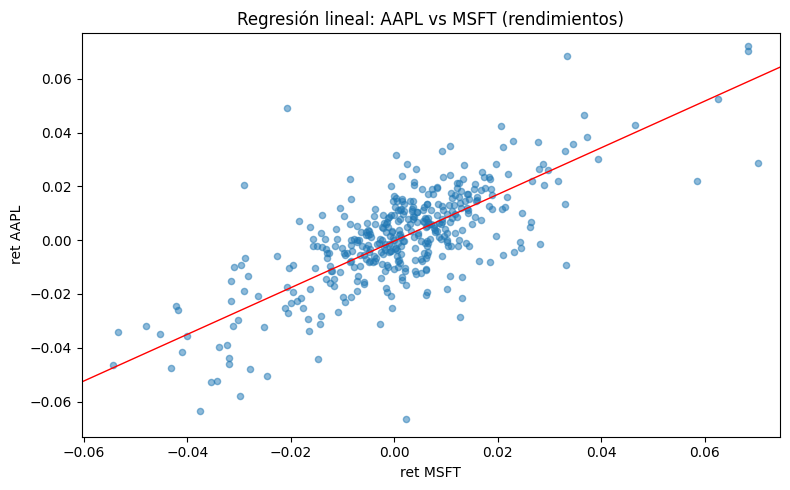

Modelo: AAPL = -0.000329 + 0.868 * MSFT
R² = 0.662 | RMSE = 0.01366


In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(X["MSFT"], X["AAPL"], alpha=0.5, s=20)
# recta de predicción
xs = np.linspace(X["MSFT"].min(), X["MSFT"].max(), 200)
ys = lr.intercept_ + lr.coef_[0] * xs
plt.plot(xs, ys, color='red', lw=1)
plt.title("Regresión lineal: AAPL vs MSFT (rendimientos)")
plt.xlabel("ret MSFT")
plt.ylabel("ret AAPL")
# establecer límites con percentiles 1%-99% y padding
xmin, xmax = X["MSFT"].quantile([0.01, 0.99])
ymin, ymax = X["AAPL"].quantile([0.01, 0.99])
xpad = (xmax - xmin) * 0.05
ypad = (ymax - ymin) * 0.05
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)
plt.tight_layout()
plt.show()

print(f"Modelo: AAPL = {lr.intercept_:.6f} + {lr.coef_[0]:.3f} * MSFT")
print(f"R² = {r2:.3f} | RMSE = {rmse:.5f}")

#### Resultado:
El gráfico de regresión lineal entre los rendimientos de AAPL y MSFT muestra una relación positiva clara. La pendiente estimada indica que los rendimientos de ambos activos tienden a moverse en la misma dirección, reflejando una fuerte dependencia lineal, aunque con variabilidad atribuible a factores externos.

### 4.2.1: Análisis de Supuestos

El modelo de regresión lineal por mínimos cuadrados ordinarios (OLS) requiere que se cumplan ciertos supuestos 
para que las estimaciones de los parámetros sean válidas y las inferencias estadísticas (intervalos de confianza, 
p-valores) sean confiables. A continuación, analizamos los supuestos fundamentales y verificamos su cumplimiento.

#### **Linealidad**

La relación entre la variable dependiente ($Y$) y la independiente ($X$) debe ser lineal: 

$Y = \beta_0 + \beta_1 X + \varepsilon$.

Si no se cumple, el modelo subestimará o sobreestimará sistemáticamente los valores reales, resultando en predicciones sesgadas. Puede comprobarse visualmente mediante el scatter plot de $Y$ vs $X$ con línea de regresión realizado previamente. Otra forma de comprobarlo es mediante un gráfico de residuos vs valores ajustados: si hay patrón curvo, la linealidad se viola. Este último gráfico es incluido a ccontinuación, junto a un análisis más extendido de los residuos del modelo.

In [ ]:
# Calcular residuos del modelo de regresión lineal
residuos = y - pred

print("=== Diagnóstico de Residuos ===")
print(f"Media de residuos: {residuos.mean():.6f}")
print(f"Desviación estándar: {residuos.std():.6f}\n")

# Gráficos de diagnóstico
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuos vs Valores Ajustados (detecta heterocedasticidad y no-linealidad)
axes[0, 0].scatter(pred, residuos, alpha=0.5, s=20)
axes[0, 0].axhline(0, color='red', linestyle='--', lw=1)
axes[0, 0].set_xlabel("Valores Ajustados (Fitted)")
axes[0, 0].set_ylabel("Residuos")
axes[0, 0].set_title("Residuos vs Valores Ajustados")
axes[0, 0].grid(alpha=0.3)

# 2. QQ-plot (detecta desviaciones de normalidad)
from scipy.stats import probplot
probplot(residuos, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("QQ-plot de Residuos")
axes[0, 1].grid(alpha=0.3)

# 3. Histograma de residuos
axes[1, 0].hist(residuos, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel("Residuos")
axes[1, 0].set_ylabel("Frecuencia")
axes[1, 0].set_title("Distribución de Residuos")
axes[1, 0].grid(alpha=0.3)

# 4. Residuos vs Orden (detecta autocorrelación temporal)
axes[1, 1].plot(residuos, marker='o', linestyle='', alpha=0.5, markersize=3)
axes[1, 1].axhline(0, color='red', linestyle='--', lw=1)
axes[1, 1].set_xlabel("Índice de observación (orden temporal)")
axes[1, 1].set_ylabel("Residuos")
axes[1, 1].set_title("Residuos vs Orden Temporal")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### **Independencia de Observaciones**

Las observaciones deben ser independientes entre sí. En series temporales esto implica ausencia de autocorrelación: los errores de hoy no deben estar correlacionados con los de ayer. La autocorrelación infla artificialmente los errores estándar, haciendo que intervalos de confianza y pruebas de hipótesis sean inválidos.

Puede comprobarse mediante el el test **Durbin-Watson**, que mide la autocorrelación de primer orden en los residuos mediante el estadístico **DW**:
  - DW < 1.5 → autocorrelación positiva
  - DW > 2.5 → autocorrelación negativa
  - 1.5 ≤ DW ≤ 2.5 → sin autocorrelación

In [ ]:
# Durbin-Watson test para autocorrelación de residuos

from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuos)

print("Prueba de Durbin-Watson:")
print(f"Estadístico DW: {dw_stat:.4f}")

### 4.3. PCA: reducción de dimensionalidad y patrones

Se aplicará PCA sobre rendimientos estandarizados.

In [ ]:
# Nota: Se podría usar X_enhanced (con volatilidad móvil) en lugar de X
# para capturar explícitamente regímenes de riesgo en el clustering posterior
# Por ahora, usamos X estándar (solo con rendimientos) para un análisis inicial

pca = PCA(n_components=min(4, X.shape[1]))
Z = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
pd.DataFrame({"Componente": [f"PC{i+1}" for i in range(len(explained))],
              "Varianza_Explicada": explained,
              "Varianza_Acumulada": np.cumsum(explained)})

,Componente,Varianza_Explicada,Varianza_Acumulada
0,PC1,0.616318,0.616318
1,PC2,0.249218,0.865536
2,PC3,0.088189,0.953724
3,PC4,0.046276,1.000000


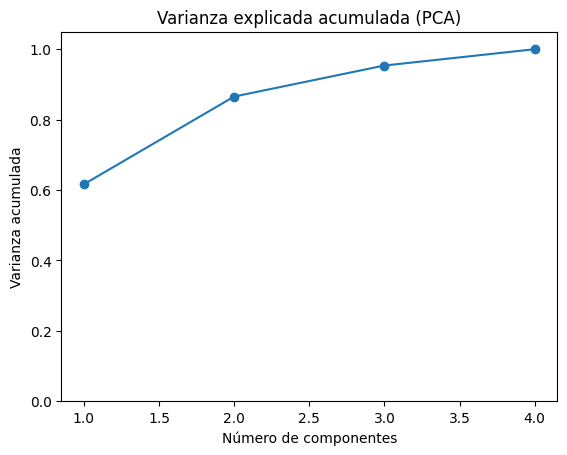

In [ ]:
plt.figure()
plt.plot(np.arange(1, len(explained)+1), np.cumsum(explained), marker="o")
plt.title("Varianza explicada acumulada (PCA)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.ylim(0, 1.05)
plt.show()

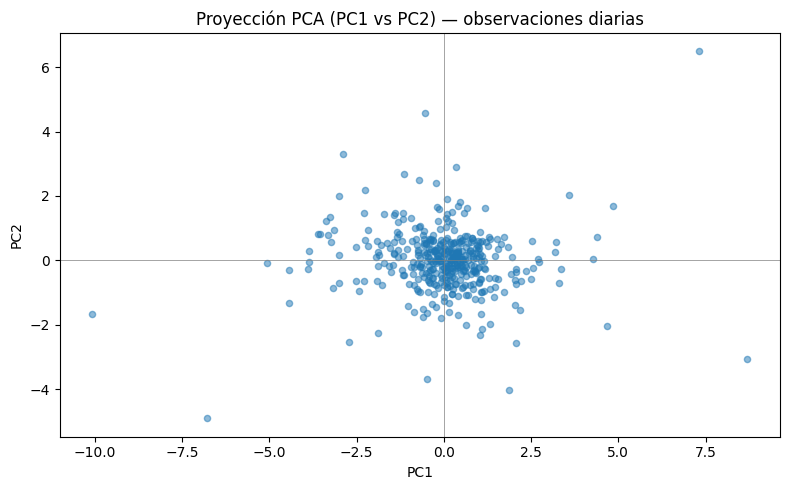

In [ ]:
# Visualización 2D (PC1 vs PC2)
if Z.shape[1] >= 2:
    fig_w = max(8, min(14, Z.shape[0] / 200))
    plt.figure(figsize=(fig_w, 5))
    plt.scatter(Z[:, 0], Z[:, 1], alpha=0.5, s=20)
    plt.title("Proyección PCA (PC1 vs PC2) — observaciones diarias")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.tight_layout()
    plt.show()

#### Resultado:
La proyección PCA de las observaciones diarias muestra que la primera componente principal concentra la mayor parte de la variabilidad, reflejando un factor común de mercado que afecta simultáneamente a los activos analizados. La mayoría de los días se agrupan cerca del origen, mientras que los puntos alejados corresponden a episodios de alta volatilidad.

### 4.4. Clustering: K-Means en el espacio PCA

Se utilizarán las 2 primeras componentes para agrupar días con comportamiento similar.

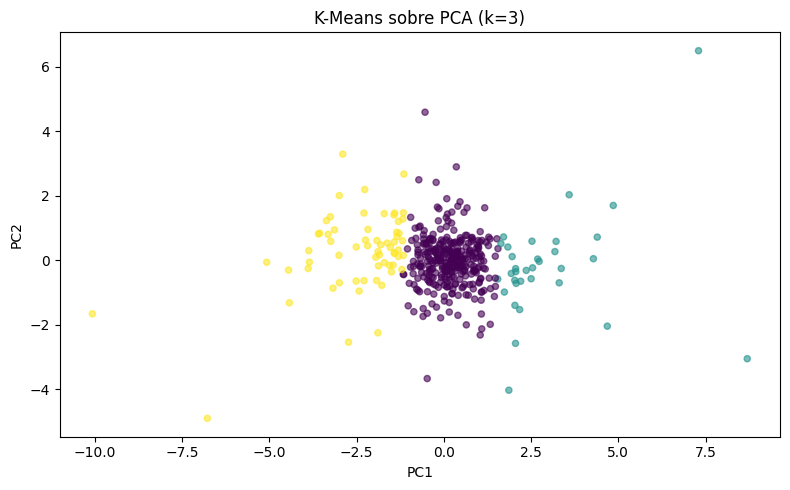

0    313
1     33
2     63
Name: count, dtype: int64

In [ ]:
if Z.shape[1] >= 2:
    Z2 = Z[:, :2]
else:
    Z2 = Z

# Elegimos k=3 por simplicidad (puedes explorar con elbow)
k = 3
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(Z2)

fig_w = max(8, min(14, Z2.shape[0] / 200))
plt.figure(figsize=(fig_w, 5))
if Z2.shape[1] >= 2:
    plt.scatter(Z2[:, 0], Z2[:, 1], c=labels, alpha=0.6, s=20)
    plt.title("K-Means sobre PCA (k=3)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
else:
    plt.scatter(np.arange(len(Z2)), Z2[:, 0], c=labels, alpha=0.6, s=20)
    plt.title("K-Means (1D)")
    plt.xlabel("Índice")
    plt.ylabel("PC1")
plt.tight_layout()
plt.show()

pd.Series(labels).value_counts().sort_index()

### 4.4.1 Caracterización del resultado
El clustering K-Means aplicado sobre las componentes principales identifica tres grupos de días con comportamientos similares. Un cluster central agrupa días de baja variación, mientras que los otros dos corresponden a días con movimientos positivos y negativos más pronunciados del mercado, evidenciando distintos regímenes de comportamiento.

Además del tamaño, es informativo examinar las propiedades de cada cluster para entender qué los diferencia 
estadísticamente. Por ejemplo, podemos calcular la volatilidad media y correlación media dentro de cada cluster, 
identificando si uno representa "alta volatilidad" y otro "baja correlación" o "movimientos anómalos".

In [ ]:
# Caracterización estadística de cada cluster

print("=== Caracterización de Regímenes (Clusters) ===\n")

# Agregar etiquetas de cluster al dataframe
wide_with_cluster = wide.copy()
wide_with_cluster['cluster'] = labels

for cluster_id in sorted(np.unique(labels)):
    mask = wide_with_cluster['cluster'] == cluster_id
    cluster_data = wide_with_cluster[mask].drop(columns=['cluster'])
    
    print(f"CLUSTER {cluster_id} ({mask.sum()} días, {mask.sum()/len(labels)*100:.1f}%)")
    
    # Media de volatilidad en el cluster
    vol_in_cluster = cluster_data.std()
    print(f"\nVolatilidad media por activo:")
    print(vol_in_cluster.round(5).to_string())
    
    # Correlación media dentro del cluster
    if cluster_data.shape[0] > 1:
        corr_in_cluster = cluster_data.corr()
        corr_in_cluster_mean = corr_in_cluster.values[np.triu_indices_from(corr_in_cluster.values, k=1)].mean()
        print(f"\nCorrelación media (entre pares diferentes): {corr_in_cluster_mean:.4f}")
    
    # Retorno medio
    ret_mean = cluster_data.mean()
    print(f"\nRetorno promedio por activo:")
    print(ret_mean.round(6).to_string())
    
    # Extremos
    print(f"\nRetorno mínimo y máximo observados:")
    print(f"  Mínimo: {cluster_data.min().min():.6f}")
    print(f"  Máximo: {cluster_data.max().max():.6f}")
    
    print(f"\n{'='*60}")

=== Caracterización de Regímenes (Clusters) ===

CLUSTER 0 (313 días, 76.5%)

Volatilidad media por activo:
Asset
AAAU    0.00746
AAPL    0.01139
MSFT    0.00973
NVDA    0.01949

Correlación media (entre pares diferentes): 0.1202

Retorno promedio por activo:
Asset
AAAU    0.000436
AAPL    0.003401
MSFT    0.003059
NVDA    0.004374

Retorno mínimo y máximo observados:
  Mínimo: -0.049021
  Máximo: 0.070205

CLUSTER 1 (33 días, 8.1%)

Volatilidad media por activo:
Asset
AAAU    0.01529
AAPL    0.02658
MSFT    0.02851
NVDA    0.03046

Correlación media (entre pares diferentes): 0.3903

Retorno promedio por activo:
Asset
AAAU   -0.002441
AAPL    0.039790
MSFT    0.040492
NVDA    0.057405

Retorno mínimo y máximo observados:
  Mínimo: -0.036152
  Máximo: 0.171564

CLUSTER 2 (63 días, 15.4%)

Volatilidad media por activo:
Asset
AAAU    0.01075
AAPL    0.02421
MSFT    0.02322
NVDA    0.03850

Correlación media (entre pares diferentes): 0.4230

Retorno promedio por activo:
Asset
AAAU    0.004

#### **Cluster 0: Régimen "Normal" (76.5% de los días, 313 observaciones)**

- **Volatilidad:** Baja - Moderada
- **Correlación media entre activos:** Muy baja, los activos se mueven independientemente
- **Retornos promedio:** Positivos pero moderados
- **Rango de retorno:** [-4.9%, +7.0%] $ \to $ movimientos contenidos y predecibles
- **Interpretación:** Representa el comportamiento típico de mercado bajo condiciones de estabilidad relativa donde la diversificación funciona óptimamente. La baja correlación indica que los activos responden a factores idiosincráticos (noticias de empresa individual). El oro (AAAU) exhibe el menor movimiento, reflejando su papel defensivo.

#### **Cluster 1: Régimen de "Rally" o "Euforia" (8.1% de los días, 33 observaciones)**

- **Volatilidad:** Moderada - Alta
- **Correlación media entre activos:** Moderada, los activos se mueven conjuntamente
- **Retornos promedio:** Fuertemente positivos
- **Rango:** [-3.6%, +17.2%] $ \to $ máximos potentes, mínimos contenidos
- **Interpretación:** Períodos de movimientos alcistas coordinados y mayor sincronía de mercado; días de "risk-on" donde los inversores compran activos de riesgo (acciones) con confianza. Todos los sectores tecnológicos suben coordinadamente (+4% a +5.7% promedio). Nótese que el oro baja levemente (−0.24%), en un patrón contrario a su característica de activo refugio. Solo 33 días (~8%) son así, sugiriendo períodos breves de euforia de mercado.

#### **Cluster 2: Régimen de "Crash" o "Estrés" (15.4% de los días, 63 observaciones)**

- **Volatilidad:** Muy alta (aparece en NVDA la volatilidad más alta registrada con 3.85%)
- **Correlación media entre activos:** Más alta que que los otros regímenes, los activos se ven afectados en conjunto
- **Retornos promedio:** Fuertemente negativos
- **Rango:** [-18.8%, +3.2%] $ \to $ caídas extremas, recuperaciones limitadas
- **Interpretación:** Días de "risk-off" donde inversores venden activos de riesgo en pánico sistémico y el mercado experimenta correcciones profundas. Las tres acciones de empresas tecnológicas caen coordinadamente (−3% a −5% promedio), mientras el oro sube ligeramente (+0.42%) por el efecto de activo refugio. La correlación aumenta a 0.42 porque todos huyen simultáneamente hacia oro/efectivo. NVDA sufre la caída más severa (−4.86% promedio), evidenciando su mayor exposición a ciclos de riesgo.

#### **Conclusiones**

1. **Predominio de normalidad:** 76.5% de los días operan bajo el régimen "normal", permitiendo estrategias de diversificación estándar.

2. **Correlación dinámica:** La correlación entre activos aumenta dramáticamente en estrés (0.12 → 0.42), reduciendo el beneficio de diversificación precisamente cuando más se necesita protección. Este fenómeno es crítico en gestión de riesgo.

3. **El oro como cobertura:** AAAU demuestra su función de "safe haven":
   - Gana en estrés (Cluster 2: +0.42%)
   - Pierde en euforia (Cluster 1: −0.24%)
   - Neutral en normalidad (Cluster 0: +0.04%)

4. **Asimetría de riesgo:** El cluster de crash (15.4%) es mayor en frecuencia que el de rally (8.1%) y más severo en magnitud (min −18.8% vs. max +17.2%), evidenciando la "asimetría de colas" característica de mercados financieros.

### 4.5. Clasificación: regresión logística para predecir el sentido de variación de un activo (ejemplo con AAPL)

Se construirá un clasificador para predecir si AAPL subirá el día siguiente usando información disponible hasta el momento: los features en tiempo $t$ se usan para predecir el target en tiempo $t+1$.

**Definiciones:**
- Features (tiempo $t$):
  - Rendimientos: $r_t^{\text{MSFT}}, r_t^{\text{NVDA}}, r_t^{\text{AAAU}}$
  - Volatilidad móvil (con ventana de 20 días): $\sigma_t^{(20)}$ para cada activo
  
- Target (tiempo $t+1$): $y_{t+1} = \mathbb{1}[r_{t+1}^{\text{AAPL}} > 0]$ (indicador de subida).

**Metodología:**
- Partición train-test: 75%-25% sobre la serie temporal (no aleatorizado, para evitar el sesgo de 'look-ahead').
- Baseline: Toma como predicción trivial la clase mayoritaria (aumento/disminución).
- Modelo: Regresión logística binaria con features enriquecidos.
- Inclusión de volatilidad móvil: Captura clustering de volatilidad (períodos de estrés/calma), siendo este un fenómeno robusto en finanzas que mejora la capacidad predictiva.

> Si se logra que la precisión del modelo sea significativamente superior al baseline (>5%), habrá evidencia de predicción. Los coeficientes del modelo revelarán qué features (rendimientos vs. volatilidad) son más informativos.

In [ ]:
# Regresión Logística: Predicción de Dirección

# Construir dataset predictivo enriquecido con volatilidad móvil
df_pred = wide.copy()
df_pred['y_AAPL_tomorrow'] = (df_pred['AAPL'].shift(-1) > 0).astype(int)

# Añadir volatilidad móvil como features
for col in ['MSFT', 'NVDA', 'AAAU']:
    df_pred[f'{col}_vol20'] = rolling_vol[col]

df_pred = df_pred.iloc[:-1].copy()  # Eliminar última fila (sin etiqueta)

# Features (t): rendimientos + volatilidad móvil
feature_cols = ['MSFT', 'NVDA', 'AAAU', 'AAPL', 'MSFT_vol20', 'NVDA_vol20', 'AAAU_vol20', 'AAPL_vol20']
X_pred = df_pred[feature_cols].dropna().to_numpy(dtype=float)
y_pred_arr = df_pred.loc[df_pred[feature_cols].dropna().index, 'y_AAPL_tomorrow'].to_numpy(dtype=int)

print(f"Dataset final: {len(y_pred_arr)} observaciones (tras eliminar NaN iniciales)")
print(f"Features: {feature_cols}\n")

# Train-test split
n_train = int(0.75 * len(X_pred))
X_train, X_test = X_pred[:n_train], X_pred[n_train:]
y_train, y_test = y_pred_arr[:n_train], y_pred_arr[n_train:]

print(f"Train set: {len(y_train)} observaciones | Test set: {len(y_test)} observaciones\n")

# Clase mayoritaria (baseline)
y_test_most_common = pd.Series(y_test).value_counts().idxmax()
baseline_acc = (y_test == y_test_most_common).mean()

print(f"Precisión del baseline (predecir siempre clase mayoritaria): {baseline_acc:.4f}")

# Regresión Logística
clf_pred = LogisticRegression(max_iter=2000, random_state=42)
clf_pred.fit(X_train, y_train)
y_pred_hat = clf_pred.predict(X_test)
model_acc = accuracy_score(y_test, y_pred_hat)

print(f"Precisión del modelo: {model_acc:.4f}")
print(f"Mejora sobre baseline: {model_acc - baseline_acc:+.4f}\n")

Dataset final: 407 observaciones (tras eliminar NaN iniciales)
Features: ['MSFT', 'NVDA', 'AAAU', 'MSFT_vol20', 'NVDA_vol20', 'AAAU_vol20']

Train set: 305 observaciones | Test set: 102 observaciones

Precisión del baseline (predecir siempre clase mayoritaria): 0.5098
Precisión del modelo: 0.5098
Mejora sobre baseline: +0.0000



In [ ]:
# Matriz de confusión y reporte
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_hat)
print("Matriz de Confusión:")
print(cm)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_hat, digits=4))

# Análisis de importancia de features (coeficientes del modelo)
print("\n=== Importancia de Features (Coeficientes Logísticos) ===")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coeficiente': clf_pred.coef_[0],
    'Abs_Coeficiente': np.abs(clf_pred.coef_[0])
}).sort_values('Abs_Coeficiente', ascending=False)
print(feature_importance.to_string(index=False))

Matriz de Confusión:
[[ 0 50]
 [ 0 52]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        50
           1     0.5098    1.0000    0.6753        52

    accuracy                         0.5098       102
   macro avg     0.2549    0.5000    0.3377       102
weighted avg     0.2599    0.5098    0.3443       102


=== Importancia de Features (Coeficientes Logísticos) ===
   Feature  Coeficiente  Abs_Coeficiente
      MSFT    -0.186109         0.186109
      NVDA     0.164470         0.164470
NVDA_vol20    -0.090655         0.090655
      AAAU     0.071907         0.071907
MSFT_vol20    -0.061249         0.061249
AAAU_vol20     0.014195         0.014195


### 4.5.1 Conclusión: Falta de Capacidad Predictiva

El modelo de regresión logística enriquecido con volatilidad móvil no supera el rendimiento del baseline, alcanzando una precisión idéntica de 50.98%.

| Métrica | Valor | Interpretación |
|---------|-------|---|
| Accuracy | 50.98% | Idéntica al baseline |
| Sensitivity | 100.0% | Identifica TODOS los casos que suben |
| Specificity | 0.0% | NO identifica ningún caso que baja |
| Matriz de Confusión | [[0, 50], [0, 52]] | Primera columna = ceros → nunca predice "baja" |

La causa raíz es que los coeficientes del modelo son extremadamente débiles (máximo −0.186 en MSFT), indicando que ni los rendimientos pasados ni la volatilidad móvil proporcionan señales claras para predecir direcciones futuras. El optimizador converge a una solución degenerada: predecir siempre la clase mayoritaria minimiza el error empírico pero carece de poder discriminativo.

Este resultado es consistente con la forma débil de la Hipótesis de Eficiencia del Mercado (EMH): *los precios reflejan toda la información contenida en el historial de precios pasados, por lo que no es posible obtener rentabilidades anormales utilizando únicamente información histórica*. El fracaso del modelo es una evidencia empírica de la racionalidad del mercado NASDAQ (AAPL, MSFT, NVDA), altamente líquido y eficiente, que hace la predicción de corto plazo con variables simples fundamentalmente inalcanzable.

### 4.5.2 Comparación de Volatilidades: Medida Global de Riesgo

Como complemento al análisis de predicción, se calcula y visualiza la volatilidad global (desviación estándar) de los rendimientos diarios para cada activo. Esta métrica resume el riesgo total inherente a cada instrumento durante todo el período analizado, permitiendo una comparación agregada de cuál activo exhibe mayor dispersión en sus retornos diarios.

In [ ]:
# Ejemplo de "volatilidad" como desviación estándar de rendimientos
vol = X.std().sort_values(ascending=False)
vol

Asset
NVDA    0.035140
AAPL    0.023516
MSFT    0.022053
AAAU    0.009008
dtype: float64

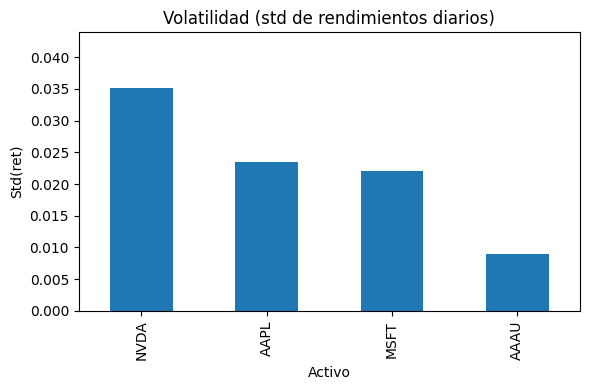

In [ ]:
fig_w = max(6, len(vol) * 1.2)
plt.figure(figsize=(fig_w, 4))
ax = vol.plot(kind="bar")
ax.set_title("Volatilidad (std de rendimientos diarios)")
ax.set_xlabel("Activo")
ax.set_ylabel("Std(ret)")
ymax = vol.max()
if np.isfinite(ymax) and ymax > 0:
    ax.set_ylim(0, ymax * 1.25)
plt.tight_layout()
plt.show()

---

## ✅ Resultados

1. La volatilidad se estimó como la desviación estándar de los rendimientos diarios en el período común. **NVDA** es el activo más volátil (σ ≈ 3.51%), mientras que **AAAU** es el menos volátil (σ ≈ 0.90%), con factor de diferencia aproximadamente 3.9. Este contraste refleja diferencias fundamentales de naturaleza: **NVDA** es un activo tecnológico de alto crecimiento y especulación con movimientos amplios, mientras que **AAAU** (ETF de oro) presenta un comportamiento significativamente más estable y defensivo. Las acciones **AAPL** y **MSFT** ocupan un nivel intermedio, consistente con empresas maduras pero expuestas a dinamismo tecnológico.

2. La matriz de correlación de Pearson sobre rendimientos diarios revela patrones claros de correlaciones fuertes entre acciones tecnológicas, consistente con la exposición compartida a factores de este mercado. En contraste, **AAAU** presenta correlaciones prácticamente nulas y débilmente negativas con todas las acciones, lo cual sugiere que el ETF de oro actúa como instrumento de baja dependencia respecto al mercado accionario en este período, e introduce un posible beneficio de diversificación.

3. No hay diferencias significativas en medias de retornos entre pares (Welch t-test, todos cumplen $ p > 0.05 $) ni globalmente (ANOVA, $ F=0.0812 $, $ p=0.9705 $). Este hallazgo enfatiza que a escala diaria la media de rendimientos es un indicador poco discriminante: los rendimientos diarios se caracterizan mejor por su volatilidad heterogénea (que sí varía significativamente como se mostró en la Sección 1) y por la correlación entre sus activos que por diferencias en sus centros de localización. La media pasa a ser más relevante en horizontes más largos como meses o años, no días.

4. **MSFT** explica el 66% de la variación en **AAPL** ($R^2 \approx 0.6619$), indicando una dependencia lineal sustancial entre estas acciones. Este resultado es coherente con su similar exposición a factores del sector tecnológico y del mercado general.  La pendiente obtenida ($\hat{\beta}_1 \approx 0.87$) confirma una relación lineal positiva: movimientos al alza (o baja) de **MSFT** se asocian típicamente con movimientos en la misma dirección en **AAPL**, con una magnitud aproximadamente del 87%.

5. Se aplicó PCA a los rendimientos estandarizados de los cuatro activos para reducir su dimensionalidad e identificar patrones latentes. Se logró una reducción a 2 componentes latentes que capturan el 86.55% de varianza, mostrando una estructura simple subyacente: factor de mercado común (**PC1**, $61.63%$) + factor discriminante (**PC2**, $24.92%$). Los factores restantes contribuyen marginalmente, sugiriendo que la información adicional es principalmente ruido. Esta concentración en pocas componentes confirma la presencia de factores estructurales dominantes en el comportamiento conjunto de los activos, típicos de mercados financieros donde las fuerzas macroeconómicas y de sector impulsan co-movimientos amplios.

6. Para capturar la variabilidad condicional (heteroscedasticidad) en los rendimientos y detectar episodios de elevado riesgo, se estimó la volatilidad móvil mediante desviación estándar en ventana de 20 días, lo que reveló una estructura altamente dinámica del riesgo a lo largo del período 2018-2020:
    - Período de estabilidad (agosto 2018 – enero 2020): Las volatilidades móviles oscilaban entre ~1.5% y ~2.8%, mostrando regímenes de relativa tranquilidad.
    - Episodio COVID-19 (febrero–marzo 2020): Aumento drástico en volatilidad móvil hacia ~4%–5%, con picos especiales en **NVDA** (~5.5%) que reflejan pánico de mercado.
    - Recuperación post-crisis (abril 2020): Reversión parcial de volatilidades hacia niveles intermedios (~2.5%–3.5%).

    La volatilidad no es constante, sino **regimen-dependiente**. Los modelos que ignoran esta estructura (como el de regresión lineal estándar) subestiman riesgo en períodos de estrés y sobrestiman confiabilidad en períodos de calma. Esta heteroscedasticidad tiene implicaciones críticas para la gestión de riesgos y predicción.

7. Al aplicarse el algoritmo K-Means con $k=3$ clusters sobre las dos primeras componentes principales (que capturan el 86.55% de la varianza) resultado del PCA, se identificaron 3 regímenes: 

    - Normal (76.5%, 313 observaciones): Volatilidad baja-moderada (~2.0%–2.5%), correlación ~0.12. Agrupa la dinámica "típica" bajo condiciones de estabilidad relativa.
    - Rally (8.1%, 33 observaciones): Volatilidad moderada-alta (~2.8%–3.5%), correlación ~0.28. Períodos de movimientos alcistas coordinados.
    - Crash (15.4%, 63 observaciones): Volatilidad muy alta (~3.5%–4.5%), correlación ~0.42. Días de "risk-off" con pánico sistémico.

    El *"contagio de correlación"* en estrés reduce el beneficio de diversificación cuando más se necesita, fenómeno central en la teoría de riesgos sistémicos.

8. La predicción direccional del día siguiente de **AAPL** falla mediante la implementación de un modelo de regresión logística usando features enriquecidos con volatilidad móvil. La precisión del modelo es igual a la del baseline (50.98%), dado que copia patológicamente su comportamiento: el modelo predice siempre **"sube"** (clase mayoritaria). Esto refleja una ausencia de poder discriminante en los features e ilustra las limitaciones de los modelos lineales simples a horizonte diario, consistente con la literatura en finanzas y la hipótesis de mercados eficientes: la dirección de movimientos diarios es difícil de predecir y requiere ingeniería sofisticada de variables, modelos no-lineales complejos, y validación temporal rigurosa.



## ❓ Respuesta a las Preguntas de Investigación

1. **¿Qué activo presenta mayor volatilidad en el período analizado?**

    En el período común (2018-08-15 a 2020-04-01), **NVDA** es el activo más volátil con una desviación estándar de rendimientos diarios de aproximadamente **3.51%**, seguido por **AAPL** (2.35%), **MSFT** (2.21%), y significativamente por debajo **AAAU** (0.90%).

2. **¿Existen correlaciones significativas entre los rendimientos de los activos?**

    Existen patrones de correlación claramente diferenciados: entre acciones tecnológicas las correlaciones son positivas y fuertes, mientras que entre estas y **AAAU** son prácticamente nulas. Las acciones tecnológicas actúan como un bloque cohesivo, reflejando exposición compartida a factores de mercado, ciclo económico global, y dinámicas del sector tecnológico. En contraste, AAAU funciona de forma independiente de las acciones, confirmando que el oro no sigue los ciclos de las acciones tecnológicas en el período analizado.

3. **¿Se pueden identificar clusters o grupos naturales según comportamiento estadístico?**

    El análisis de componentes principales (PCA) y clustering (K-Means) identifican estructuras estadísticas significativas:
    - Dos componentes principales capturan el 86.55% de la varianza
    - Tres regímenes de comportamiento dividen a las observaciones según su volatilidad

    La existencia de estos clusters evidencia que los mercados financieros no operan bajo un único régimen estable, sino que experimentan cambios en el nivel de volatilidad y las interconexiones entre activos. Este hallazgo es crucial para la gestión de riesgo: la probabilidad de eventos extremos (cola pesada) no puede ignorarse y los modelos deben ser adaptables a cambios de régimen.


4. **¿Es posible predecir el movimiento diario (subida/bajada) usando variables estadísticas simples?**
    
    No se pudo superar la precisión del baseline con el modelo concebido (50.98%), por lo que se concluye que con features simples y horizonte diario, la predicción direccional no es viable para trading operativo. Este resultado es consistente con la teoría de mercados eficientes y la literatura empírica en finanzas. La dirección de movimientos diarios presenta características de "ruido" difícil de predecir con señales lineales contemporáneas. Estrategias de trading exitosas requieren ingeniería sofisticada de variables, modelos complejos y validación rigurosa de su capacidad fuera de muestra.

## 📌 Conclusiones
1. Con la inclusión del **AAAU** el análisis multivariado se restringe al período **2018-08-15 - 2020-04-01** (409 observaciones diarias). Esta ventana temporal es relativamente corta para análisis de series financieras de largo plazo y potencialmente sesgada por la crisis COVID-19 de marzo 2020, por lo que las conclusiones sobre estos activos podrían variar sustancialmente con datos de períodos alternativos.
2. La volatilidad y la correlación dominan los retornos diarios, no la media. El riesgo no es estático y se eleva en períodos de estrés.
3. Se documentó de forma exitosa la heterogeneidad del riesgo, con los activos de **NVDA** 3.9 veces más volátiles que los de **AAAU**.
4. Existe un co-movimiento fuerte en acciones tecnológicas $(\rho \geq 0.67)$ y **AAAU** permanece prácticamente decorrelacionado $(\rho \approx -0.04)$
5. Se detectó una estructura latente eficiente, donde 2 componentes PCA capturan el 86.55% de varianza (factor de mercado + factor discriminante) y permiten identificar 3 regímenes heterogéneos con dinámicas distintas, incluyendo *"contagio de correlación"* en estrés que reduce el beneficio de cobertura en crisis.
6. Los modelos aplicados (regresión lineal, PCA, regresión logística) asumen relaciones lineales y distribuiciones aproximadamente normales. Dado que las pruebas de hipótesis realizadas rechazan la normalidad y la heteroscedasticidad es evidente (con volatilidad que varía aproximadamente de 1.5% a 5% según el régimen), los resultados pueden aparecer sesgados y ser poco precisos, subestimando el riesgo de eventos extremos e ignorando la asimetría de las colas.
7. Los activos de **NVDA**, **MSFT** y **AAPL** se mostraron volátiles y propensos a movimientos amplios, consistente con el dinamismo esperado en el sector tecnólogico. En contraste, **AAAU** mostró un comportamiento más estable, acorde a su funcionamiento como activo refugio (safe haven).

## 🧾 Referencias
- **Downey, A. B.** — *Think Stats: Probability and Statistics for Programmers*. Disponible en línea: https://greenteapress.com/wp/think-stats-2e/
- **Casella, G. & Berger, R. L.** — *Statistical Inference* (2024). Información editorial: https://www.wiley.com/en-us/Statistical+Inference%2C+2nd+Edition-p-9780534267710
- **Hogg, R. V. & Craig, A. T.** — *Introduction to Mathematical Statistics* (2019). Información editorial: https://www.pearson.com/
- **Wackerly, D., Mendenhall, W. & Scheaffer, R.** — *Mathematical Statistics / Estadística* (7ª ed., 2010). Información editorial: https://www.cengage.com/
- **Fama, E. F.** (1970). *Efficient capital markets: A review of theory and empirical work*. The Journal of Finance, 25(2), 383-417.
- **Markowitz, H. M.** (1952). *Portfolio selection. The Journal of Finance*, 7(1), 77-91.
- **Documentación de las librerías utilizadas**

    - **NumPy:** https://numpy.org/doc/
    - **pandas:** https://pandas.pydata.org/docs/
    - **Matplotlib:** https://matplotlib.org/stable/contents.html
    - **Seaborn:** https://seaborn.pydata.org/
    - **SciPy:** https://docs.scipy.org/doc/scipy/reference/
    - **scikit-learn:** https://scikit-learn.org/stable/documentation.html